In [1]:
!pip install tensorflow scikit-learn pandas numpy rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 60.4 MB/s eta 0:00:00


In [20]:
# --- Install Dependencies ---
# !pip install tensorflow scikit-learn pandas numpy rdkit

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray, TanimotoSimilarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Load and clean data
def load_data(xlsx_path):
    df = pd.read_excel(xlsx_path, usecols=['Drug1', 'Drug2', 'Y'], dtype=str)
    df = df.dropna().reset_index(drop=True)
    df = df[df['Drug1'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]
    df = df[df['Drug2'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]
    df['Y'] = df['Y'].astype(int)
    return df


# Generate fingerprints
def generate_fingerprints(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    maccs = MACCSkeys.GenMACCSKeys(mol)
    fp = np.zeros((nBits + 167,), dtype=np.float32)
    ConvertToNumpyArray(morgan, fp[:nBits])
    ConvertToNumpyArray(maccs, fp[nBits:])
    return fp



In [31]:
# Prepare features and labels
def prepare_dataset(df, sim_threshold=0.3, total_limit=190000):
    pos_limit = total_limit // 2

    unique_smiles = list(set(df['Drug1']).union(set(df['Drug2'])))
    fingerprints = {smi: generate_fingerprints(smi) for smi in unique_smiles}

    all_positives = df[df['Y'] == 1][['Drug1', 'Drug2']].values.tolist()
    if len(all_positives) > pos_limit:
        positives = random.sample(all_positives, pos_limit)
    else:
        positives = all_positives
        pos_limit = len(positives)  # update if less available

    # Sample negatives
    neg_samples = []
    while len(neg_samples) < pos_limit:
        d1, d2 = random.sample(unique_smiles, 2)
        if [d1, d2] in positives or [d2, d1] in positives:
            continue
        sim = TanimotoSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles(d1)),
                                 Chem.RDKFingerprint(Chem.MolFromSmiles(d2)))
        if sim < sim_threshold:
            neg_samples.append([d1, d2])

    data = positives + neg_samples
    labels = [1] * len(positives) + [0] * len(neg_samples)

    X1 = np.array([fingerprints[d1] for d1, d2 in data])
    X2 = np.array([fingerprints[d2] for d1, d2 in data])
    y = np.array(labels)

    return X1, X2, y



# Build model
def build_model(input_dim):
    inp1 = Input(shape=(input_dim,), name='drug1_fp')
    inp2 = Input(shape=(input_dim,), name='drug2_fp')

    def subnet(x):
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        return x

    x1 = subnet(inp1)
    x2 = subnet(inp2)
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inp1, inp2], outputs=out)
    model.compile(optimizer=Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


In [22]:
# Main execution
xlsx_path = "drugbank_ddi_dataset.xlsx"  # replace with your actual file path
df = load_data(xlsx_path)




In [32]:
X1, X2, y = prepare_dataset(df, sim_threshold=0.3, total_limit=190000)

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)



In [33]:
model = build_model(X1.shape[1])
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("hybrid_ddi_model_final.h5", save_best_only=True)
]

history = model.fit([X1_train, X2_train], y_train,
                    validation_data=([X1_val, X2_val], y_val),
                    epochs=20, batch_size=128, callbacks=callbacks, verbose=1)



Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7215 - loss: 0.5513 - precision_2: 0.7206 - recall_2: 0.7228

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7216 - loss: 0.5512 - precision_2: 0.7206 - recall_2: 0.7229 - val_accuracy: 0.8380 - val_loss: 0.3686 - val_precision_2: 0.8094 - val_recall_2: 0.8859
Epoch 2/20
1176/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8329 - loss: 0.3816 - precision_2: 0.8163 - recall_2: 0.8580

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8329 - loss: 0.3815 - precision_2: 0.8163 - recall_2: 0.8580 - val_accuracy: 0.8607 - val_loss: 0.3241 - val_precision_2: 0.8342 - val_recall_2: 0.9017
Epoch 3/20
1182/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8551 - loss: 0.3384 - precision_2: 0.8339 - recall_2: 0.8865

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8551 - loss: 0.3384 - precision_2: 0.8339 - recall_2: 0.8865 - val_accuracy: 0.8735 - val_loss: 0.3009 - val_precision_2: 0.8495 - val_recall_2: 0.9090
Epoch 4/20
1175/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8688 - loss: 0.3135 - precision_2: 0.8442 - recall_2: 0.9045

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8688 - loss: 0.3135 - precision_2: 0.8442 - recall_2: 0.9045 - val_accuracy: 0.8859 - val_loss: 0.2801 - val_precision_2: 0.8598 - val_recall_2: 0.9232
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - loss: 0.2929 - precision_2: 0.8525 - recall_2: 0.9124

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8774 - loss: 0.2929 - precision_2: 0.8525 - recall_2: 0.9124 - val_accuracy: 0.8903 - val_loss: 0.2695 - val_precision_2: 0.8670 - val_recall_2: 0.9231
Epoch 6/20
1179/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2798 - precision_2: 0.8581 - recall_2: 0.9182

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8834 - loss: 0.2798 - precision_2: 0.8581 - recall_2: 0.9182 - val_accuracy: 0.8960 - val_loss: 0.2606 - val_precision_2: 0.8780 - val_recall_2: 0.9208
Epoch 7/20
1183/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8884 - loss: 0.2705 - precision_2: 0.8621 - recall_2: 0.9237

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8884 - loss: 0.2705 - precision_2: 0.8621 - recall_2: 0.9237 - val_accuracy: 0.9016 - val_loss: 0.2492 - val_precision_2: 0.8643 - val_recall_2: 0.9538
Epoch 8/20
1180/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2611 - precision_2: 0.8667 - recall_2: 0.9297

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8938 - loss: 0.2612 - precision_2: 0.8667 - recall_2: 0.9297 - val_accuracy: 0.9048 - val_loss: 0.2448 - val_precision_2: 0.8716 - val_recall_2: 0.9503
Epoch 9/20
1180/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8967 - loss: 0.2534 - precision_2: 0.8699 - recall_2: 0.9327

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8967 - loss: 0.2534 - precision_2: 0.8699 - recall_2: 0.9327 - val_accuracy: 0.9091 - val_loss: 0.2365 - val_precision_2: 0.8754 - val_recall_2: 0.9548
Epoch 10/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9021 - loss: 0.2441 - precision_2: 0.8757 - recall_2: 0.9371

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9021 - loss: 0.2441 - precision_2: 0.8757 - recall_2: 0.9371 - val_accuracy: 0.9083 - val_loss: 0.2350 - val_precision_2: 0.8766 - val_recall_2: 0.9512
Epoch 11/20
1181/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9045 - loss: 0.2387 - precision_2: 0.8769 - recall_2: 0.9411

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9045 - loss: 0.2387 - precision_2: 0.8769 - recall_2: 0.9411 - val_accuracy: 0.9133 - val_loss: 0.2293 - val_precision_2: 0.8830 - val_recall_2: 0.9536
Epoch 12/20
1183/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9071 - loss: 0.2353 - precision_2: 0.8801 - recall_2: 0.9426

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9071 - loss: 0.2353 - precision_2: 0.8801 - recall_2: 0.9426 - val_accuracy: 0.9146 - val_loss: 0.2253 - val_precision_2: 0.8819 - val_recall_2: 0.9582
Epoch 13/20
1174/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9120 - loss: 0.2256 - precision_2: 0.8848 - recall_2: 0.9479

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9119 - loss: 0.2257 - precision_2: 0.8848 - recall_2: 0.9478 - val_accuracy: 0.9156 - val_loss: 0.2248 - val_precision_2: 0.8864 - val_recall_2: 0.9540
Epoch 14/20
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - loss: 0.2238 - precision_2: 0.8834 - recall_2: 0.9478

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9117 - loss: 0.2239 - precision_2: 0.8834 - recall_2: 0.9478 - val_accuracy: 0.9158 - val_loss: 0.2236 - val_precision_2: 0.8800 - val_recall_2: 0.9637
Epoch 15/20
1173/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - loss: 0.2231 - precision_2: 0.8828 - recall_2: 0.9479

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9114 - loss: 0.2231 - precision_2: 0.8828 - recall_2: 0.9479 - val_accuracy: 0.9187 - val_loss: 0.2171 - val_precision_2: 0.8899 - val_recall_2: 0.9563
Epoch 16/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9147 - loss: 0.2181 - precision_2: 0.8870 - recall_2: 0.9495 - val_accuracy: 0.9181 - val_loss: 0.2197 - val_precision_2: 0.8833 - val_recall_2: 0.9643
Epoch 17/20
1173/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9162 - loss: 0.2133 - precision_2: 0.8870 - recall_2: 0.9539

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9162 - loss: 0.2134 - precision_2: 0.8870 - recall_2: 0.9539 - val_accuracy: 0.9213 - val_loss: 0.2131 - val_precision_2: 0.8920 - val_recall_2: 0.9593
Epoch 18/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9178 - loss: 0.2109 - precision_2: 0.8911 - recall_2: 0.9516 - val_accuracy: 0.9223 - val_loss: 0.2132 - val_precision_2: 0.8912 - val_recall_2: 0.9627
Epoch 19/20
1184/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9198 - loss: 0.2063 - precision_2: 0.8921 - recall_2: 0.9541

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9198 - loss: 0.2063 - precision_2: 0.8921 - recall_2: 0.9541 - val_accuracy: 0.9226 - val_loss: 0.2105 - val_precision_2: 0.8897 - val_recall_2: 0.9654
Epoch 20/20
1185/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9219 - loss: 0.2010 - precision_2: 0.8942 - recall_2: 0.9564

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9219 - loss: 0.2011 - precision_2: 0.8942 - recall_2: 0.9564 - val_accuracy: 0.9247 - val_loss: 0.2094 - val_precision_2: 0.8958 - val_recall_2: 0.9619


In [34]:
# Evaluation
val_preds = model.predict([X1_val, X2_val]).flatten()
val_preds_bin = (val_preds >= 0.5).astype(int)
train_preds = model.predict([X1_train, X2_train]).flatten()
train_preds_bin = (train_preds >= 0.5).astype(int)

print("\nTrain Report:")
print(classification_report(y_train, train_preds_bin))

print("\nValidation Report:")
print(classification_report(y_val, val_preds_bin))

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Train Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     76072
           1       0.91      0.98      0.95     75928

    accuracy                           0.94    152000
   macro avg       0.95      0.94      0.94    152000
weighted avg       0.95      0.94      0.94    152000


Validation Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     18928
           1       0.90      0.96      0.93     19072

    accuracy                           0.92     38000
   macro avg       0.93      0.92      0.92     38000
weighted avg       0.93      0.92      0.92     38000



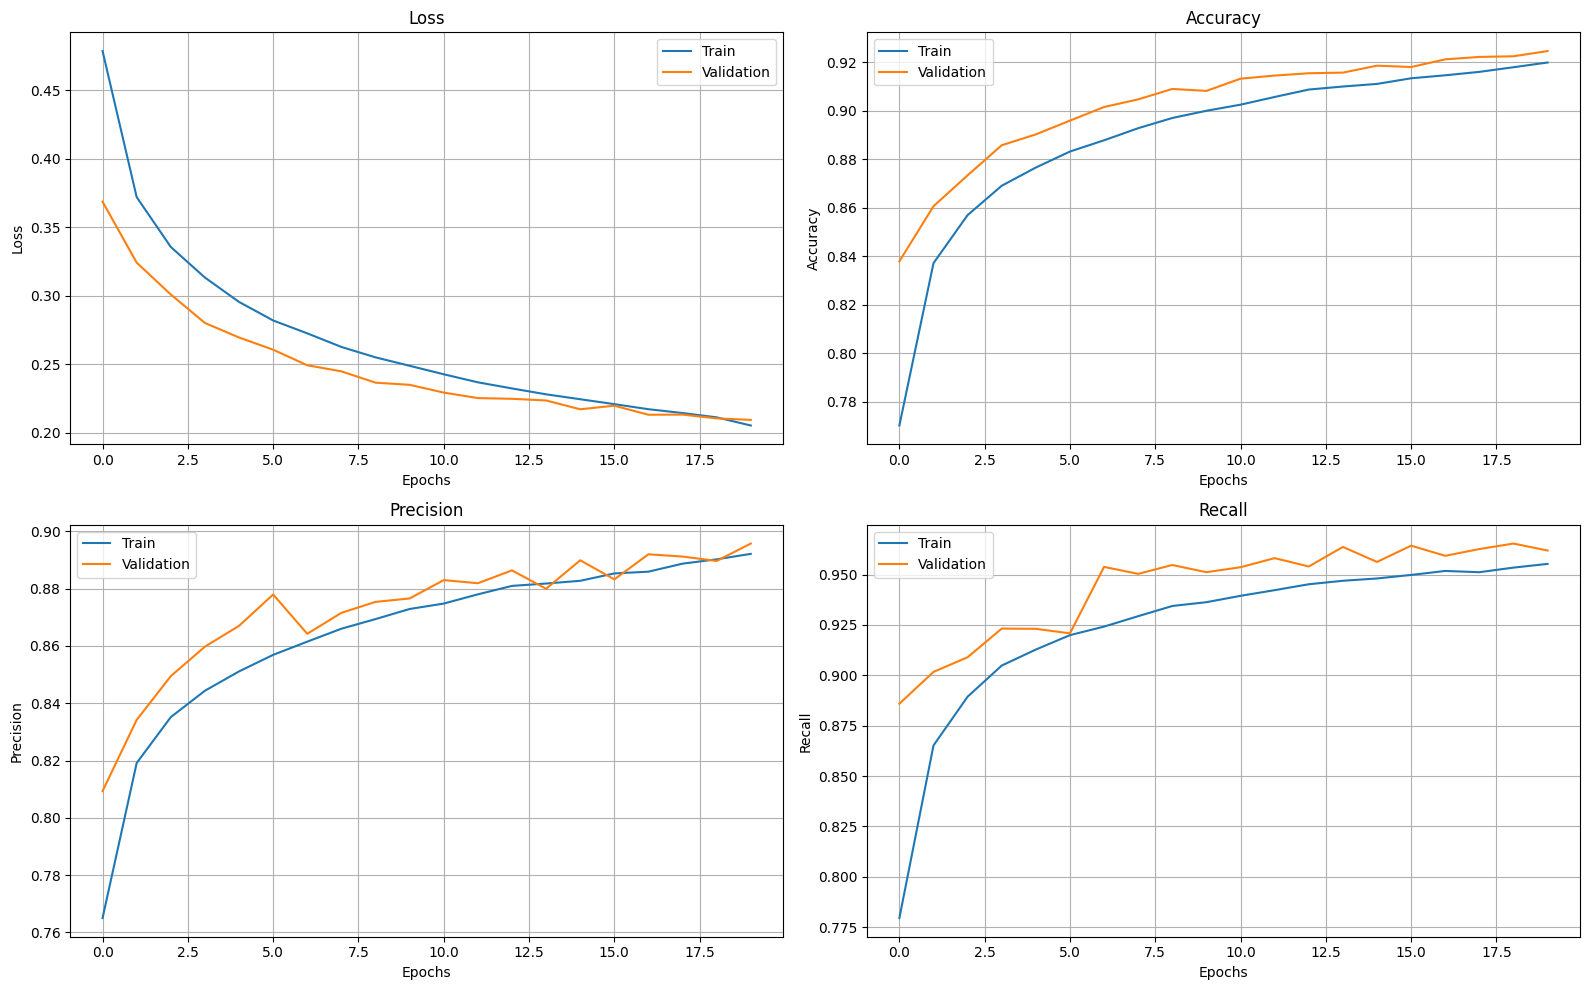

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    available_metrics = history.history.keys()
    metric_base_names = ['loss', 'accuracy', 'precision', 'recall']

    plt.figure(figsize=(16, 10))
    subplot_index = 1

    for base in metric_base_names:
        # Find actual metric key (e.g., 'precision' or 'precision_1')
        train_key = next((k for k in available_metrics if k.startswith(base) and not k.startswith('val_')), None)
        val_key = next((k for k in available_metrics if k.startswith(f'val_{base}')), None)

        if train_key and val_key:
            plt.subplot(2, 2, subplot_index)
            plt.plot(history.history[train_key], label='Train')
            plt.plot(history.history[val_key], label='Validation')
            plt.title(base.capitalize())
            plt.xlabel('Epochs')
            plt.ylabel(base.capitalize())
            plt.legend()
            plt.grid(True)
            subplot_index += 1

    plt.tight_layout()
    plt.show()


plot_history(history)


In [ ]:
from google.colab import files
files.download("hybrid_ddi_model_final.h5")
